In [125]:
import pandas as pd
import numpy as np
rename_dict = {
    'clientID': 'client',
    'trDte': 'visit_date', 
    'itemGroup': 'item_group'
}

transaction = pd.read_csv('transaction_.csv')
transaction = transaction.rename(columns=rename_dict)
# Преобразование даты (уже с новым именем)
transaction['visit_date'] = pd.to_datetime(transaction['visit_date'], format='%d.%m.%Y')
print(transaction.head(5))

transaction_raw = pd.read_csv('transaction.csv')
print("Исходные колонки:", transaction_raw.columns.tolist())

  visit_date          bcode       client      item  \
0 2017-09-01  code000000001  client13166   sku8444   
1 2017-09-01  code000000001  client13166  sku12545   
2 2017-09-01  code000000001  client13166   sku3391   
3 2017-09-01  code000000001  client13166  sku20444   
4 2017-09-01  code000000002   client1239  sku29959   

                     item_group  quantity  amount  
0              Скобяные изделия         1      29  
1  Оборудование для сада и дачи         1     329  
2                   Инструменты         1     169  
3                   Инструменты         2     578  
4              Скобяные изделия         1     329  
Исходные колонки: ['trDte', 'bcode', 'clientID', 'item', 'itemGroup', 'quantity', 'amount']


In [126]:

print("1. ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print(f"Количество строк: {transaction.shape[0]}")
print(f"Количество столбцов: {transaction.shape[1]}")
print("\nТипы данных:")
print(transaction.dtypes)
print("\nПример первых 5 строк:")
print(transaction.head())

print("\n\n2. ОПИСАТЕЛЬНАЯ СТАТИСТИКА (quantity, amount)")
numeric_cols = ['quantity', 'amount']

# Проверка, существуют ли колонки
missing_cols = [col for col in numeric_cols if col not in transaction.columns]
if missing_cols:
    print(f"Не найдены колонки: {missing_cols}")
    print("Доступные колонки:", transaction.columns.tolist())
else:
    # Приведём к числовому типу на случай, если они object
    transaction['quantity'] = pd.to_numeric(transaction['quantity'], errors='coerce')
    transaction['amount'] = pd.to_numeric(transaction['amount'], errors='coerce')

    # Основные статистики
    stats = transaction[numeric_cols].describe()

    # Добавим медиану (50% уже есть, но назовём явно)
    median = transaction[numeric_cols].median()
    stats.loc['median'] = median

    print(stats.T.round(2))  # Транспонируем и округляем для красоты

1. ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ
Количество строк: 1008688
Количество столбцов: 7

Типы данных:
visit_date    datetime64[ns]
bcode                 object
client                object
item                  object
item_group            object
quantity               int64
amount                 int64
dtype: object

Пример первых 5 строк:
  visit_date          bcode       client      item  \
0 2017-09-01  code000000001  client13166   sku8444   
1 2017-09-01  code000000001  client13166  sku12545   
2 2017-09-01  code000000001  client13166   sku3391   
3 2017-09-01  code000000001  client13166  sku20444   
4 2017-09-01  code000000002   client1239  sku29959   

                     item_group  quantity  amount  
0              Скобяные изделия         1      29  
1  Оборудование для сада и дачи         1     329  
2                   Инструменты         1     169  
3                   Инструменты         2     578  
4              Скобяные изделия         1     329  


2. ОПИСАТЕЛЬНАЯ СТАТИСТИКА

In [127]:
def aggregate_client_daily_items(df):
    required_cols = {'client', 'visit_date', 'item', 'item_group', 'quantity', 'amount'}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(f"Не хватает колонок после переименования: {missing_cols}")

    if df['visit_date'].isnull().sum() > 0:
        print(f"⚠️  Удалено {df['visit_date'].isnull().sum()} строк с некорректной датой.")
        df = df.dropna(subset=['visit_date'])

    grouped = (df
               .groupby(['client', 'visit_date', 'item', 'item_group'], as_index=False)
               .agg({'quantity': 'sum', 'amount': 'sum'})
               .rename(columns={'visit_date': 'visit_date'}))

    # Сортировка
    result = grouped.sort_values(by=['client', 'visit_date', 'item']).reset_index(drop=True)
    return result

# print(transaction.head(10))
print(aggregate_client_daily_items(transaction).head(5))
print(f'Кол-во значений в таблице: {len(aggregate_client_daily_items(transaction))}')


     client visit_date      item     item_group  quantity  amount
0   client1 2018-01-22  sku10765  Лаки и краски         1      29
1   client1 2018-01-22  sku13695  Стойматериалы         5    1535
2   client1 2018-01-22  sku29083  Лаки и краски         2     310
3   client1 2018-01-22   sku2954  Лаки и краски         1     399
4  client10 2019-08-05   sku1893    Инструменты         1      79
Кол-во значений в таблице: 1003083


Задача: на дату актуальности (конец периода наблюдения) рассчитать для каждого клиента его профиль с
RFM и дополнительными признаками.

Напиши функцию calculate_client_profile_at_date(visits_df,
observation_end_date).
Функция должна:
1. Фильтровать визиты СТРОГО ДО observation_end_date
(visit_date < observation_end_date)
Это важно для метода аналогий — нет утечки данных!
2. Для каждого клиента рассчитать RFM признаки:
 - Recency: количество дней между последним визитом и
observation_end_date
- Frequency: количество УНИКАЛЬНЫХ ДАТ визитов (не товаров!)
 - Monetary: общая сумма всех покупок
3. Дополнительные признаки:
 - last_visit_date: дата последнего визита
 - total_quantity: общее количество товаров
 - avg_check: средний чек (Monetary / Frequency)
- total_unique_items: количество уникальных товаров за
историю
 - avg_items_per_visit: среднее количество товаров на визит
 - weekend_visits: количество визитов в субботу и воскресенье
 - amount_last_visit: сумма последнего визита
4. Вернуть DataFrame с профилями, отсортированный по client.

In [128]:
def calculate_client_profile_at_date(visits_df, observation_end_date):
    """Профиль клиентов на дату (только визиты до этой даты)."""
    
    obs_date = pd.to_datetime(observation_end_date)
    visits = visits_df.copy()
    visits['visit_date'] = pd.to_datetime(visits['visit_date'], errors='coerce')
    visits = visits.dropna(subset=['visit_date'])
    
    visits = visits[visits['visit_date'] < obs_date]
    if visits.empty:
        return pd.DataFrame()
    
    visits['is_weekend'] = visits['visit_date'].dt.dayofweek >= 5
    
    # Основные агрегации
    agg = visits.groupby('client').agg(
        last_visit=('visit_date', 'max'),
        visits=('visit_date', 'count'),
        unique_visits=('visit_date', 'nunique'),
        amount=('amount', 'sum'),
        quantity=('quantity', 'sum'),
        items=('item', 'nunique'),
        weekends=('is_weekend', 'sum')
    ).reset_index()
    
    # Расчет метрик
    agg['Recency'] = (obs_date - agg['last_visit']).dt.days
    agg['Frequency'] = agg['unique_visits']
    agg['Monetary'] = agg['amount']
    agg['avg_check'] = agg['amount'] / agg['Frequency']
    agg['avg_items'] = agg['quantity'] / agg['Frequency']
    
    # Сумма последнего визита
    last_amount = visits.loc[visits.groupby('client')['visit_date'].idxmax()]
    agg = agg.merge(last_amount[['client', 'amount']].rename(
        columns={'amount': 'last_visit_amount'}), on='client')
    
    return agg.sort_values('client').reset_index(drop=True)

observation_end_date = '2019-09-01'
print(calculate_client_profile_at_date(transaction, observation_end_date).head(10))
print(f"Всего клиентов: {len(calculate_client_profile_at_date(transaction, observation_end_date))}")
client_profile = calculate_client_profile_at_date(transaction, observation_end_date)


        client last_visit  visits  unique_visits  amount  quantity  items  \
0      client1 2018-01-22       4              1    2273         9      4   
1     client10 2019-08-05       3              1    4757         3      3   
2    client100 2019-05-08       1              1    7299         1      1   
3   client1000 2019-08-24      32             12   31792       151     28   
4  client10000 2018-08-01       5              1    8495         5      5   
5  client10001 2019-08-11      18              5    1874        33     18   
6  client10002 2019-05-30      18              4    5850        25     18   
7  client10003 2019-08-31     149             39   54360       577    110   
8  client10004 2019-07-28      38             10    7204        50     35   
9  client10005 2019-05-08      24              5    4846        33     22   

   weekends  Recency  Frequency  Monetary    avg_check  avg_items  \
0         0      587          1      2273  2273.000000   9.000000   
1         0   

In [129]:
def mark_events(visits_df, result_start_date, result_end_date):

    start_date = pd.to_datetime(result_start_date)
    end_date = pd.to_datetime(result_end_date)

    base_clients = visits_df['client'].unique()
    
    period_mask = (visits_df['visit_date'] >= start_date) & (visits_df['visit_date'] < end_date)
    active_clients = visits_df.loc[period_mask, 'client'].unique()
    
    # 3. Создаем DataFrame только для базовых клиентов
    result = pd.DataFrame({
        'client': base_clients,
        'event': [1 if client in active_clients else 0 for client in base_clients]
    })
    
    return result

result_start_date, result_end_date = '2019-09-01', '2019-10-01'

daily_summary = aggregate_client_daily_items(transaction)

daily_summary['visit_date'] = pd.to_datetime(daily_summary['visit_date'])

min_date = daily_summary['visit_date'].min().date()
max_date = daily_summary['visit_date'].max().date()

event_labels = mark_events(daily_summary, result_start_date, result_end_date)
print(f"Количество уникальных клиентов: {len(event_labels)}")
print(f"Количество вернувшихся: {event_labels['event'].sum()}")
print(f"Процент вернувшихся: {event_labels['event'].mean() * 100:.1f}%")
print(f"Клиентов, НЕ посетивших: {(event_labels['event'] == 0).sum()} ({(1 - event_labels['event'].mean()) * 100:.1f}%)")

print("\nРазметка событий (первые 15 строк):")
print(event_labels.head(15).to_string(index=False))



Количество уникальных клиентов: 42746
Количество вернувшихся: 8821
Процент вернувшихся: 20.6%
Клиентов, НЕ посетивших: 33925 (79.4%)

Разметка событий (первые 15 строк):
     client  event
    client1      0
   client10      0
  client100      0
 client1000      1
client10000      0
client10001      0
client10002      0
client10003      1
client10004      1
client10005      0
client10006      0
client10007      0
client10008      0
client10009      0
 client1001      0


In [130]:
def create_train_df(profile_df, events_df):
    # 1. INNER JOIN по client
    df = profile_df.merge(events_df, on='client', how='inner')

    # 2. Проверяем отсутствие пропусков в целевой переменной event
    if df['event'].isna().any():
        raise ValueError("Ошибка: целевая переменная 'event' содержит пропуски!")

    # Приводим event к булевому типу (True/False)
    df['event'] = df['event'].astype(bool)

    # 3. Удаляем служебные колонки с датами
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    df = df.drop(columns=date_cols, errors='ignore')

    # 4. Проверяем наличие обоих классов
    if df['event'].nunique() < 2:
        raise ValueError("В выборке только один класс события (нужно и True, и False)!")
    
    # print(f"Готовая обучающая выборка: {df.shape[0]} строк, {df.shape[1]} признаков")

    # 5. Возвращаем выборку
    return df

profile_df = calculate_client_profile_at_date(transaction, observation_end_date)
events_df = mark_events(transaction, result_start_date, result_end_date)

train_df = create_train_df(profile_df, events_df)

print(f"Готовая обучающая выборка: {train_df.shape[0]} строк, {train_df.shape[1]} признаков")
train_df = train_df.loc[:, ~train_df.columns.duplicated()]
print(f"После удаления дубликатов в train_df:")
print(f"Колонки: {train_df.columns.tolist()}")
# ========================================================
print("\nРаспределение классов:\n", train_df['event'].value_counts())
print("\nДоля классов (%):\n", train_df['event'].value_counts(normalize=True) * 100)
print("\nПризнаки выборки:\n", list(train_df.columns))

print("\nПример обучающей выборки (первые 10 строк):")
print("=" * 80)

print(train_df.head(10).to_string(index=False))


Готовая обучающая выборка: 39906 строк, 15 признаков
После удаления дубликатов в train_df:
Колонки: ['client', 'last_visit', 'visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount', 'event']

Распределение классов:
 event
False    32375
True      7531
Name: count, dtype: int64

Доля классов (%):
 event
False    81.128151
True     18.871849
Name: proportion, dtype: float64

Признаки выборки:
 ['client', 'last_visit', 'visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount', 'event']

Пример обучающей выборки (первые 10 строк):
     client last_visit  visits  unique_visits  amount  quantity  items  weekends  Recency  Frequency  Monetary   avg_check  avg_items  last_visit_amount  event
    client1 2018-01-22       4              1    2273         9      4         0      587          1      2273 2273.0

In [131]:
profile2 = calculate_client_profile_at_date(
    daily_summary, #aggregate_client_daily_items
    observation_end_date='2019-10-01')

print("Профиль на 2019-10-01 построен")
print(f"Клиентов: {len(profile2)}")

events2 = mark_events(daily_summary, result_start_date='2019-10-01', result_end_date='2019-11-01')

print(f"Всего клиентов: {len(events2)}")
print(f"Вернулись в октябре: {events2['event'].sum()}")


test_data = create_train_df(profile2, events2)

print("Тестовая выборка создана")
print(f"Размер: {test_data.shape[0]} клиентов, {test_data.shape[1]} признаков")

test_data = test_data.loc[:, ~test_data.columns.duplicated()]
print(f"После удаления дубликатов в test_data:")
print(f"Колонки: {test_data.columns.tolist()}")
# =============================================================

test_data = test_data.copy()  # Чтобы не было предупреждений

# Добавим метку периода и типа данных
test_data['_sample_date'] = '2019-10-01'
test_data['_target_period'] = '2019-10'
test_data['_dataset_type'] = 'test'

event_counts = test_data['event'].value_counts()
if True in event_counts:
    print(f"event = True:  {event_counts[True]} ({100 * event_counts[True] / len(test_data):.1f}%)")
if False in event_counts:
    print(f"event = False: {event_counts[False]} ({100 * event_counts[False] / len(test_data):.1f}%)")

print("\nПример данных (первые 8 строк):")
print(test_data.head(8)[['client', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'event', '_target_period']].to_string(index=False))
rain_df = train_df.loc[:, ~train_df.columns.duplicated()]
test_data = test_data.loc[:, ~test_data.columns.duplicated()]

print(f"После удаления дубликатов:")
print(f"train_df колонки: {train_df.columns.tolist()}")
print(f"test_data колонки: {test_data.columns.tolist()}")

profile2.to_csv('results/profile2_.csv', index=False, encoding='utf-8-sig')
events2.to_csv('results/events2_.csv', index=False, encoding='utf-8-sig')
test_data.to_csv('results/test_data.csv', index=False, encoding='utf-8-sig')
train_df.to_csv('results/train_data.csv', index=False, encoding='utf-8-sig')

print("Все датасеты сохранены")

check_train = pd.read_csv('results/train_data.csv')
check_test = pd.read_csv('results/test_data.csv')
print("\nФайлы успешно проверены: можно прочитать обратно.")
print(f"Обучающая: {check_train.shape}")
print(f"Тестовая: {check_test.shape}")


Профиль на 2019-10-01 построен
Клиентов: 41196
Всего клиентов: 42746
Вернулись в октябре: 9324
Тестовая выборка создана
Размер: 41196 клиентов, 15 признаков
После удаления дубликатов в test_data:
Колонки: ['client', 'last_visit', 'visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount', 'event']
event = True:  7774 (18.9%)
event = False: 33422 (81.1%)

Пример данных (первые 8 строк):
     client  Recency  Frequency  Monetary   avg_check  event _target_period
    client1      617          1      2273 2273.000000  False        2019-10
   client10       57          1      4757 4757.000000  False        2019-10
  client100      146          1      7299 7299.000000   True        2019-10
 client1000       17         13     36495 2807.307692   True        2019-10
client10000      426          1      8495 8495.000000  False        2019-10
client10001       51          5      1874  374.800000  False  

Загрузка данных...
Успешно
Обучающая выборка: (39906, 15)
Тестовая выборка:  (41196, 18)

🧮 Обучение BinningProcess...
BinningProcess обучен

NFORMATION VALUE (IV) — отсортировано по убыванию
         Variable       IV
          Recency 1.182696
    unique_visits 0.838749
        Frequency 0.838749
           visits 0.634528
            items 0.612131
         quantity 0.588133
           amount 0.481972
         Monetary 0.481972
         weekends 0.436189
        avg_items 0.170903
        avg_check 0.053070
last_visit_amount 0.020511

ИНТЕРПРЕТАЦИЯ ПО IV:
  Recency                   | IV=1.183 | 🔥 Очень сильный
  unique_visits             | IV=0.839 | 🔥 Очень сильный
  Frequency                 | IV=0.839 | 🔥 Очень сильный
  visits                    | IV=0.635 | 🔥 Очень сильный
  items                     | IV=0.612 | 🔥 Очень сильный
  quantity                  | IV=0.588 | 🔥 Очень сильный
  amount                    | IV=0.482 | 🟠 Сильный
  Monetary                  | IV=0.482 | 🟠

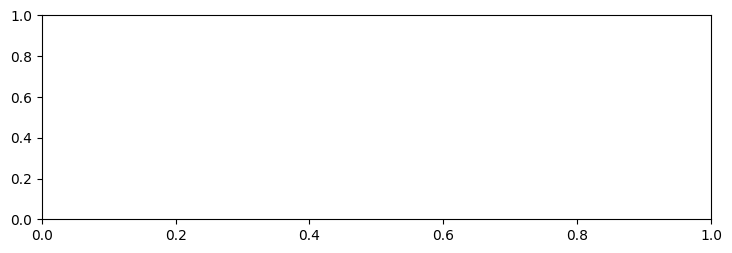

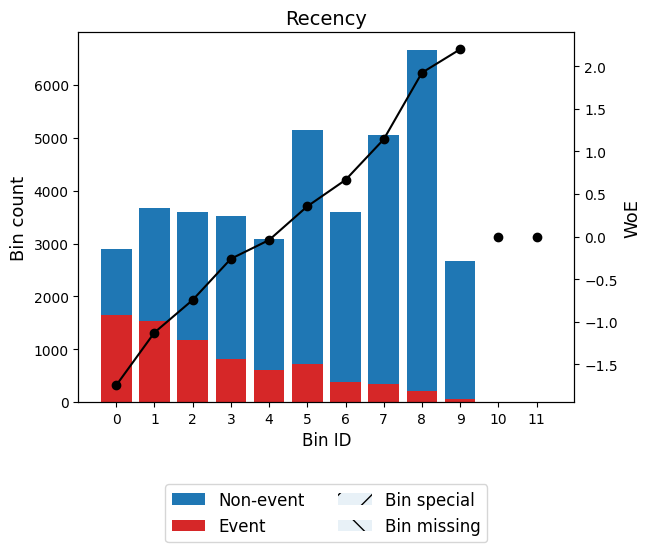

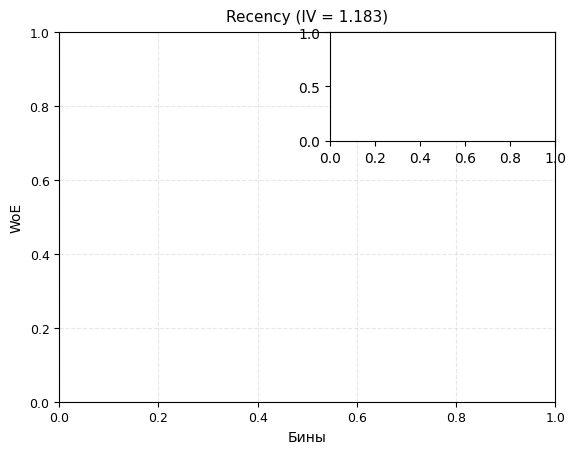

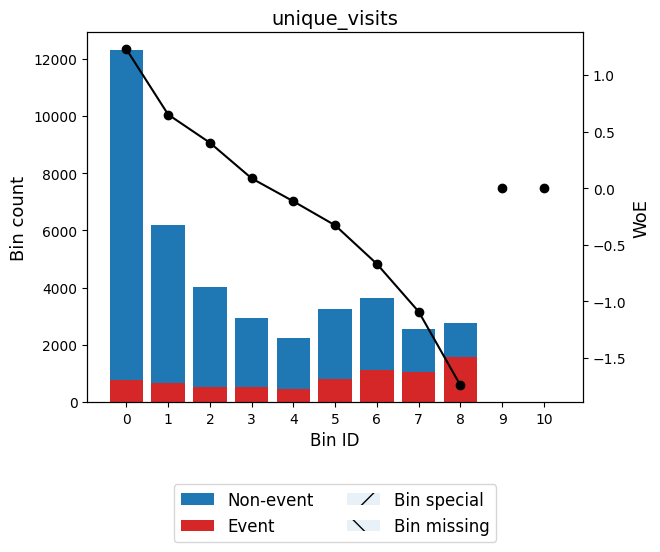

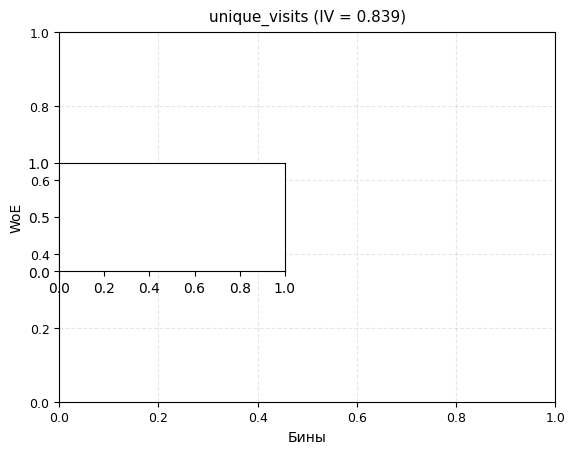

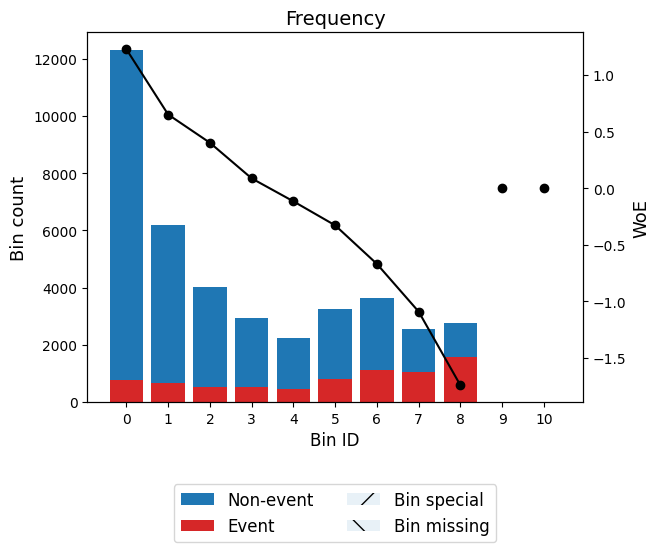

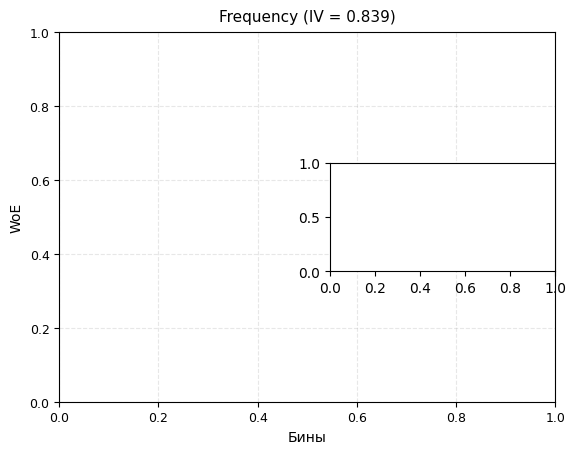

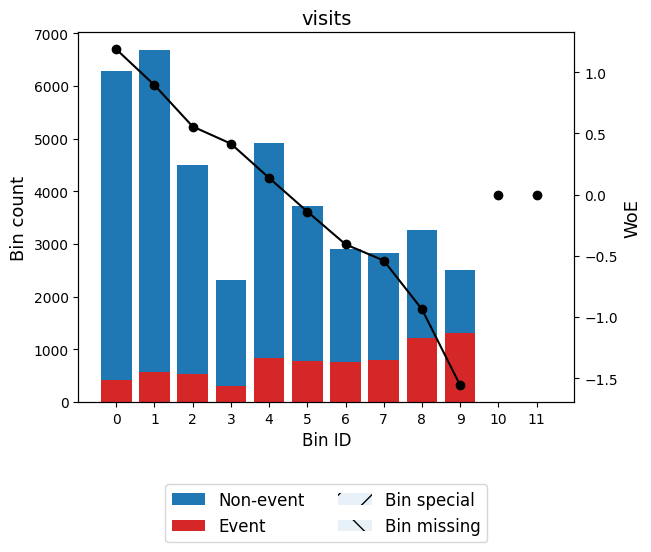

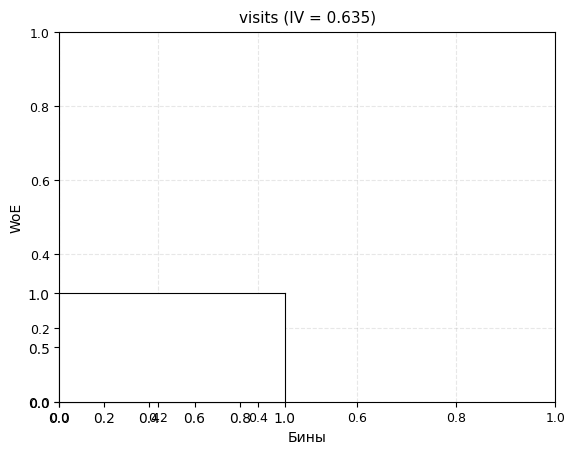

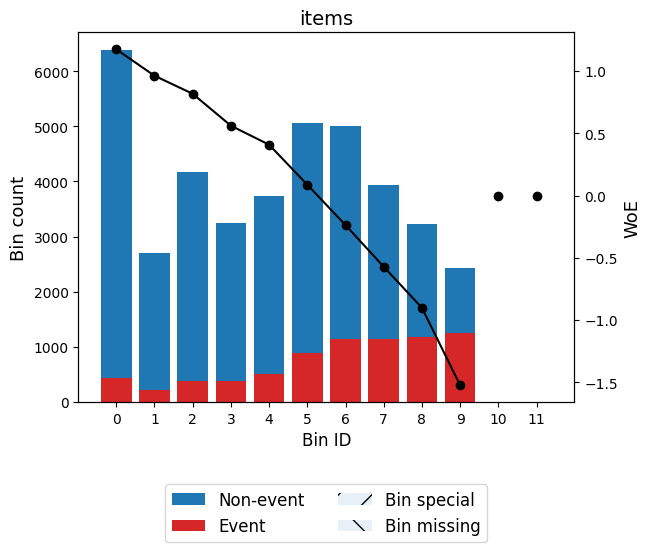

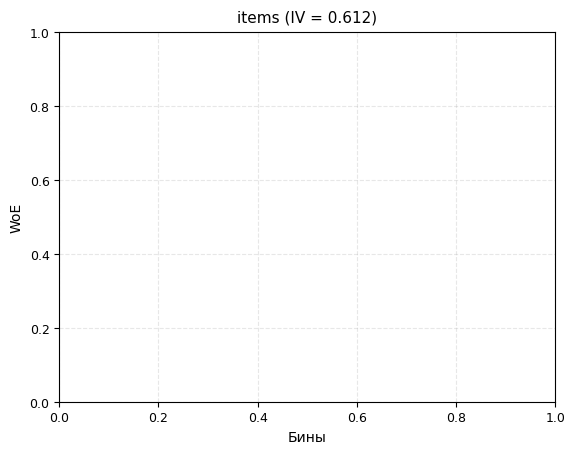


Преобразование X_train и X_test в WoE...
X_train_woe: (39906, 12), X_test_woe: (41196, 12)
Готово!
   • train_woe.csv
   • test_woe.csv
BinningProcess сохранён в 'binning_process_test.pkl'

Загрузка данных из results/test_data.csv...
Колонки в данных: ['client', 'last_visit', 'visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount', 'event', '_sample_date', '_target_period', '_dataset_type']

Числовые признаки: ['visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount']
Кол-во признаков: 12

Признаки в binning_process: ['visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount']

X_new_woe преобразован: (41196, 12)
Преобразованные данные сохранены в 'results/X_new_woe_test.csv'


In [133]:
import os
import matplotlib.pyplot as plt
from optbinning import BinningProcess
import pickle


train_path = 'results/train_data.csv'
test_path = 'results/test_data.csv'

print("Загрузка данных...")
try:
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    print(f"Успешно")
    print(f"Обучающая выборка: {train_data.shape}")
    print(f"Тестовая выборка:  {test_data.shape}")
except FileNotFoundError as e:
    raise FileNotFoundError(f"Файл не найден. Проверьте путь:\n{e}")

if 'event' not in train_data.columns or 'event' not in test_data.columns:
    raise ValueError("В данных отсутствует колонка 'event'")

X_train = train_data.drop(columns=['clientID', 'event'], errors='ignore')
y_train = train_data['event']

X_test = test_data.drop(columns=['clientID', 'event'], errors='ignore')
y_test = test_data['event']

X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Синхронизация колонок
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

numerical_features = X_train.columns.tolist()
# print(f"Признаки: {len(numerical_features)} числовых")

print("\n🧮 Обучение BinningProcess...")
binning_process = BinningProcess(
    variable_names=numerical_features,
    min_n_bins=3,
    max_n_bins=10,
    min_bin_size=0.05
)

binning_process.fit(X_train, y_train)
print("BinningProcess обучен")

print("\nNFORMATION VALUE (IV) — отсортировано по убыванию")
print("=" * 70)

iv_data = []
for var in numerical_features:
    # Получаем биннер
    optb = binning_process.get_binned_variable(var)
    # Строим таблицу — это гарантирует вычисление IV
    table = optb.binning_table.build()
    # Теперь можно получить IV
    iv = optb.binning_table.iv
    iv_data.append({'Variable': var, 'IV': iv})

iv_summary = pd.DataFrame(iv_data).sort_values(by='IV', ascending=False).reset_index(drop=True)
print(iv_summary.to_string(index=False))

# Интерпретация IV
def interpret_iv(iv):
    if iv < 0.02: return "❌ Очень слабый"
    elif iv < 0.1: return "🟡 Слабый"
    elif iv < 0.3: return "🟢 Умеренный"
    elif iv < 0.5: return "🟠 Сильный"
    else: return "🔥 Очень сильный"

iv_summary['Интерпретация'] = iv_summary['IV'].apply(interpret_iv)
print("\nИНТЕРПРЕТАЦИЯ ПО IV:")
for _, row in iv_summary.iterrows():
    print(f"  {row['Variable']:25} | IV={row['IV']:.3f} | {row['Интерпретация']}")


top5_vars = iv_summary['Variable'].head(5)
print(f"\nТАБЛИЦЫ WoE ДЛЯ ТОП-5 ПРИЗНАКОВ")
print("=" * 90)
for var in top5_vars:
    optb = binning_process.get_binned_variable(var)
    woe_table = optb.binning_table.build()  # Строим явно
    print(f"\n🔹 {var.upper()} (IV = {optb.binning_table.iv:.3f})")
    print(woe_table[['Bin', 'Count', 'Count (%)', 'Non-event', 'Event', 'WoE']])

print("\nРисуем диаграммы WoE для топ-5 признаков...")
# Увеличиваем размер фигуры для лучшей читаемости
plt.figure(figsize=(19, 9))

for i, var in enumerate(top5_vars):
    plt.subplot(3, 2, i + 1)  # Изменено на 2x3 сетку
    
    # Получаем BinningTable (не вызываем .build() как DataFrame!)
    optb = binning_process.get_binned_variable(var)
    binning_table = optb.binning_table  # ← это объект BinningTable
    
    # Строим таблицу (не сохраняем как переменную!)
    binning_table.build()  # ← теперь внутри есть данные
    
    # Рисуем график — он сам использует matplotlib
    binning_table.plot()   # ← рисует WoE

    # Получаем текущие оси и добавляем заголовок
    ax = plt.gca()
    ax.set_title(f"{var} (IV = {binning_table.iv:.3f})", fontsize=11, pad=8)
    ax.set_xlabel("Бины", fontsize=10)
    ax.set_ylabel("WoE", fontsize=10)
    
    # Уменьшаем размер шрифта меток на осях
    ax.tick_params(axis='both', which='major', labelsize=9)
    
    # Делаем легкую сетку для лучшей читаемости
    ax.grid(True, alpha=0.3, linestyle='--')

# Настраиваем компоновку для лучшего использования пространства
# plt.tight_layout(pad=2.0, h_pad=2.5, w_pad=2.5)
plt.show()

print("\nПреобразование X_train и X_test в WoE...")
X_train_woe = binning_process.transform(X_train, metric="woe")
X_test_woe = binning_process.transform(X_test, metric="woe")
print(f"X_train_woe: {X_train_woe.shape}, X_test_woe: {X_test_woe.shape}")

output_dir = 'results'
train_woe = pd.concat([
    train_data[['client', 'event']].reset_index(drop=True),
    pd.DataFrame(X_train_woe, columns=numerical_features)
], axis=1)

test_woe = pd.concat([
    test_data[['client', 'event']].reset_index(drop=True),
    pd.DataFrame(X_test_woe, columns=numerical_features)
], axis=1)

train_woe.to_csv(os.path.join(output_dir, 'train_woe.csv'), index=False, encoding='utf-8-sig')
test_woe.to_csv(os.path.join(output_dir, 'test_woe.csv'), index=False, encoding='utf-8-sig')

print("Готово!")
print("   • train_woe.csv")
print("   • test_woe.csv")

# 1. Сохранение binning_process
with open("binning_process_test.pkl", "wb") as f:
    pickle.dump(binning_process, f)
print("BinningProcess сохранён в 'binning_process_test.pkl'")

# 2. Загрузка binning_process
with open("binning_process_test.pkl", "rb") as f:
    binning_process_loaded = pickle.load(f)

# 3. Загрузка ИСХОДНЫХ данных (не WoE) для трансформации
# Используйте тестовые данные или другие исходные данные
X_new_path = 'results/test_data.csv'  # или 'results/train_data.csv'
print(f"\nЗагрузка данных из {X_new_path}...")
X_new_df = pd.read_csv(X_new_path)

print(f"Колонки в данных: {X_new_df.columns.tolist()}")

# 4. Подготовка X_new так же, как при обучении
X_new = X_new_df.drop(columns=['clientID', 'event'], errors='ignore')
X_new = X_new.select_dtypes(include=[np.number])

print(f"\nЧисловые признаки: {X_new.columns.tolist()}")
print(f"Кол-во признаков: {len(X_new.columns)}")

# 5. Синхронизация с binning_process
# Получаем список признаков из binning_process
required_features = binning_process_loaded.variable_names
print(f"\nПризнаки в binning_process: {required_features}")

# Создаем DataFrame с нужными колонками
X_new_aligned = pd.DataFrame()

for feature in required_features:
    if feature in X_new.columns:
        X_new_aligned[feature] = X_new[feature]
    else:
        print(f"Признак '{feature}' отсутствует. Заполняем нулями.")
        X_new_aligned[feature] = 0


# 6. Преобразуем в WoE
X_new_woe = binning_process_loaded.transform(X_new_aligned, metric="woe")

print(f"\nX_new_woe преобразован: {X_new_woe.shape}")

# 7. Сохраняем результат
X_new_woe_df = pd.DataFrame(X_new_woe, columns=required_features)
X_new_woe_df.to_csv("results/X_new_woe_test.csv", index=False, encoding='utf-8-sig')
print("Преобразованные данные сохранены в 'results/X_new_woe_test.csv'")


